In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d, median_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

## Produce synthetic data

In [2]:
def S_hs(QD, phi):
    alpha = (1 + 2 * phi)**2 / (1 - phi)**4
    beta = -6 * phi * (1 + phi / 2)**2 / (1 - phi)**4
    gama = phi * alpha / 2
    
    G_hs = (alpha * (np.sin(QD) - QD * np.cos(QD)) / QD**2 +
            beta * (2 * QD * np.sin(QD) + (2 - QD**2) * np.cos(QD) - 2) / QD**3 +
            gama * (-QD**4 * np.cos(QD) + 4 * ((3 * QD**2 - 6) * np.cos(QD) +
            (QD**3 - 6 * QD) * np.sin(QD) + 6)) / QD**5)
    
    S = 1 / (24 * phi * G_hs/ QD + 1)
    
    return S

def P_hs(QD):
    P = (3*(np.sin(QD/2)-QD/2*np.cos(QD/2))/(QD/2)**3)**2
    P[QD==0] = 1    
    return P

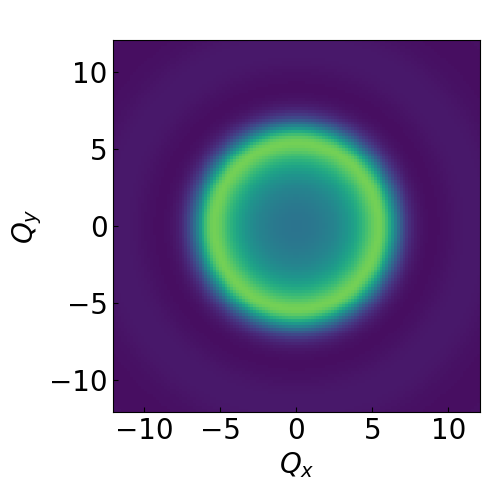

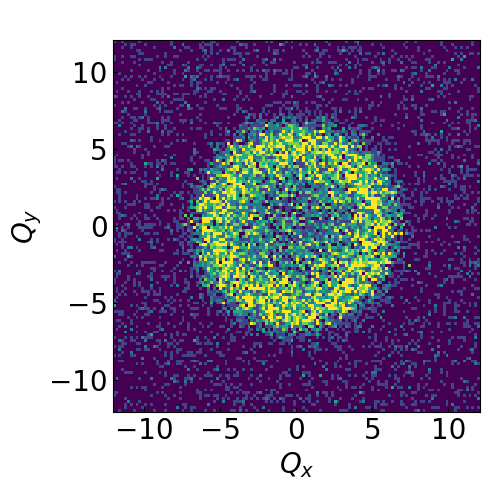

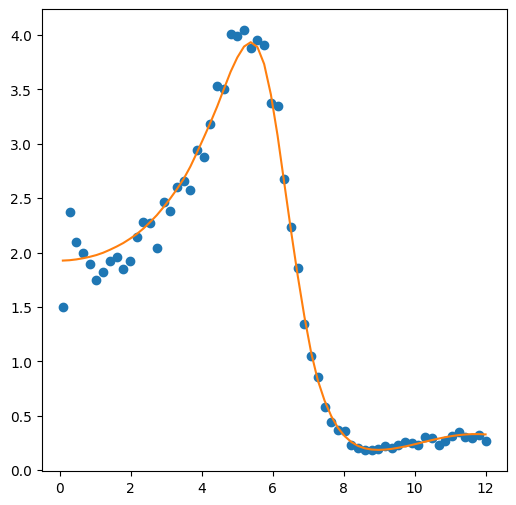

In [3]:
n_sample = 16000
q_grid = np.linspace(-12, 12, 128)
qx, qy = np.meshgrid(q_grid, q_grid)
q_rad = np.sqrt(qx**2 + qy**2)
I_inc = 0.01

p_qxy = P_hs(q_rad)*S_hs(q_rad, 0.3) + I_inc
# p_qxy =p_debye(q_rad, Rg=1)+ I_inc
p_qxy[np.isfinite(p_qxy)==0] = 0
p_qxy = p_qxy/np.sum(p_qxy)

fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

ax.pcolormesh(qx, qy, p_qxy*n_sample, cmap='viridis', vmax=5, vmin=0)
ax.set_xlabel(r'$Q_x$', fontsize=20)
ax.set_ylabel(r'$Q_y$', fontsize=20)
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([-10, -5, 0, 5, 10])
ax.tick_params(direction='in', labelsize=20)
ax.set_title(' ', fontsize=20)
plt.tight_layout()


#### generate random samples
n_pixel = n_sample/p_qxy.shape[0]  # number of samples per pixel

# Flatten the arrays
bin_edges = np.append(q_grid - (q_grid[1] - q_grid[0]) / 2, q_grid[-1] + (q_grid[1] - q_grid[0]) / 2)
d_bins = bin_edges[1] - bin_edges[0]
q = q_grid[q_grid > 0]

def f_I_q(n_sample, p_qxy, seed =19810):
    np.random.seed(seed)
    n_pixel = n_sample/p_qxy.shape[0]  # number of samples per pixel

    # Flatten the arrays
    qx_flat = qx.flatten()
    qy_flat = qy.flatten()
    p_qxy_flat = p_qxy.flatten()

    # Normalize the probability density
    p_qxy_flat /= p_qxy_flat.sum()

    # Randomly choose indices based on the probability density
    indices = np.random.choice(len(qx_flat), size=n_sample, p=p_qxy_flat)

    # Get the sampled qx and qy values
    qx_samples = qx_flat[indices]
    qy_samples = qy_flat[indices]

    # evaluate the sampled point density in each grid

    I_q_grid, xedges, yedges = np.histogram2d(qx_samples, qy_samples, bins=[bin_edges, bin_edges])

    return I_q_grid

def f_I_q_rad(I_q_grid, q):
    # evaluate the radial averaged density
    q = q_grid[q_grid > 0]
    I_q = np.zeros_like(q)
    sum_q = np.zeros_like(q)
    n_pixels_q = np.zeros_like(q)
    I_pixels_q = []
    for i in range(len(q)):
        mask = (q_rad >= q[i] - (q[1] - q[0]) / 2) & (q_rad < q[i] + (q[1] - q[0]) / 2)
        I_pixels = I_q_grid[mask]
        sum_q[i] = I_pixels.sum()
        n_pixels_q[i] = mask.sum()
        I_q[i] = I_pixels.mean()
        
        I_pixels_q.append(I_pixels)
        
        
    return I_q, sum_q, n_pixels_q, I_pixels_q

I_q_grid = f_I_q(n_sample, p_qxy) ## count per pixel
I_q, sum_q, n_pixels_q, I_pixels_q = f_I_q_rad(I_q_grid, q)
I_q_th, _, _, _ = f_I_q_rad(p_qxy, q)
I_q_th = I_q_th*n_sample

# Plot the sampled point density
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)
ax.pcolormesh(qx, qy, I_q_grid.T, cmap='viridis', vmax=5, vmin=0)
ax.set_xlabel(r'$Q_x$', fontsize=20)
ax.set_ylabel(r'$Q_y$', fontsize=20)
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([-10, -5, 0, 5, 10])
ax.tick_params(direction='in', labelsize=20)
ax.set_title(' ', fontsize=20)
plt.tight_layout()

# Plot the radial averaged density
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)
ax.plot(q, I_q, 'o')

ax.plot(q, I_q_th, '-')

## Animation: 2D spectra of different total count

In [7]:
n_sample_list = np.array([100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000, 500000, 1000000, 2000000, 5000000, 10000000, 20000000, 50000000, 100000000])

q_grid = np.linspace(-12, 12, 128)
qx, qy = np.meshgrid(q_grid, q_grid)
q_rad = np.sqrt(qx**2 + qy**2)
I_inc = 0.01
p_qxy = P_hs(q_rad)*S_hs(q_rad, 0.3) + I_inc
# p_qxy =p_debye(q_rad, Rg=1)+ I_inc
p_qxy[np.isfinite(p_qxy)==0] = 0
p_qxy = p_qxy/np.sum(p_qxy)

for n_sample in n_sample_list:
    #### generate random samples
    n_pixel = n_sample/p_qxy.shape[0]  # number of samples per pixel

    # Flatten the arrays
    bin_edges = np.append(q_grid - (q_grid[1] - q_grid[0]) / 2, q_grid[-1] + (q_grid[1] - q_grid[0]) / 2)
    d_bins = bin_edges[1] - bin_edges[0]
    q = q_grid[q_grid > 0]

    def f_I_q(n_sample, p_qxy, seed =19810):
        np.random.seed(seed)
        n_pixel = n_sample/p_qxy.shape[0]  # number of samples per pixel

        # Flatten the arrays
        qx_flat = qx.flatten()
        qy_flat = qy.flatten()
        p_qxy_flat = p_qxy.flatten()

        # Normalize the probability density
        p_qxy_flat /= p_qxy_flat.sum()

        # Randomly choose indices based on the probability density
        indices = np.random.choice(len(qx_flat), size=n_sample, p=p_qxy_flat)

        # Get the sampled qx and qy values
        qx_samples = qx_flat[indices]
        qy_samples = qy_flat[indices]

        # evaluate the sampled point density in each grid

        I_q_grid, xedges, yedges = np.histogram2d(qx_samples, qy_samples, bins=[bin_edges, bin_edges])

        return I_q_grid

    def f_I_q_rad(I_q_grid, q):
        # evaluate the radial averaged density
        q = q_grid[q_grid > 0]
        I_q = np.zeros_like(q)
        sum_q = np.zeros_like(q)
        n_pixels_q = np.zeros_like(q)
        I_pixels_q = []
        for i in range(len(q)):
            mask = (q_rad >= q[i] - (q[1] - q[0]) / 2) & (q_rad < q[i] + (q[1] - q[0]) / 2)
            I_pixels = I_q_grid[mask]
            sum_q[i] = I_pixels.sum()
            n_pixels_q[i] = mask.sum()
            I_q[i] = I_pixels.mean()
            
            I_pixels_q.append(I_pixels)
            
            
        return I_q, sum_q, n_pixels_q, I_pixels_q

    I_q_grid = f_I_q(n_sample, p_qxy) ## count per pixel
    I_q, sum_q, n_pixels_q, I_pixels_q = f_I_q_rad(I_q_grid, q)
    I_q_th, _, _, _ = f_I_q_rad(p_qxy, q)
    I_q_th = I_q_th*n_sample
    I_q_grid = I_q_grid#*16000/n_sample
    
    filename = './data/synth/Iq_sampled_'+str(n_sample)+'.dat'
    np.savetxt(filename, I_q_grid)
    
    y_err = np.sqrt(n_sample/np.sum(n_pixels_q)/np.maximum(n_pixels_q,np.ones_like(q)))
    np.savetxt('./data/synth/Iq_sampled_1d_'+str(n_sample)+'.dat', np.c_[q, I_q, y_err], header='Q I(Q) Delta I(Q)')
    
    
np.savetxt('./data/synth/qx.dat', qx)
np.savetxt('./data/synth/qy.dat', qy)

In [4]:
n_sample_list = np.array([100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000, 500000, 1000000, 2000000, 5000000, 10000000, 20000000, 50000000, 100000000])

q_grid = np.linspace(-12, 12, 128)
qx, qy = np.meshgrid(q_grid, q_grid)
q_rad = np.sqrt(qx**2 + qy**2)
I_inc = 0.01
p_qxy = P_hs(q_rad)*S_hs(q_rad, 0.3) + I_inc
# p_qxy =p_debye(q_rad, Rg=1)+ I_inc
p_qxy[np.isfinite(p_qxy)==0] = 0
p_qxy = p_qxy/np.sum(p_qxy)

# for n_sample in n_sample_list:
#     #### generate random samples
#     n_pixel = n_sample/p_qxy.shape[0]  # number of samples per pixel

#     # Flatten the arrays
#     bin_edges = np.append(q_grid - (q_grid[1] - q_grid[0]) / 2, q_grid[-1] + (q_grid[1] - q_grid[0]) / 2)
#     d_bins = bin_edges[1] - bin_edges[0]
#     q = q_grid[q_grid > 0]

#     def f_I_q(n_sample, p_qxy, seed =19810):
#         np.random.seed(seed)
#         n_pixel = n_sample/p_qxy.shape[0]  # number of samples per pixel

#         # Flatten the arrays
#         qx_flat = qx.flatten()
#         qy_flat = qy.flatten()
#         p_qxy_flat = p_qxy.flatten()

#         # Normalize the probability density
#         p_qxy_flat /= p_qxy_flat.sum()

#         # Randomly choose indices based on the probability density
#         indices = np.random.choice(len(qx_flat), size=n_sample, p=p_qxy_flat)

#         # Get the sampled qx and qy values
#         qx_samples = qx_flat[indices]
#         qy_samples = qy_flat[indices]

#         # evaluate the sampled point density in each grid

#         I_q_grid, xedges, yedges = np.histogram2d(qx_samples, qy_samples, bins=[bin_edges, bin_edges])

#         return I_q_grid

#     def f_I_q_rad(I_q_grid, q):
#         # evaluate the radial averaged density
#         q = q_grid[q_grid > 0]
#         I_q = np.zeros_like(q)
#         sum_q = np.zeros_like(q)
#         n_pixels_q = np.zeros_like(q)
#         I_pixels_q = []
#         for i in range(len(q)):
#             mask = (q_rad >= q[i] - (q[1] - q[0]) / 2) & (q_rad < q[i] + (q[1] - q[0]) / 2)
#             I_pixels = I_q_grid[mask]
#             sum_q[i] = I_pixels.sum()
#             n_pixels_q[i] = mask.sum()
#             I_q[i] = I_pixels.mean()
            
#             I_pixels_q.append(I_pixels)
            
            
#         return I_q, sum_q, n_pixels_q, I_pixels_q

#     I_q_grid = f_I_q(n_sample, p_qxy) ## count per pixel
#     I_q, sum_q, n_pixels_q, I_pixels_q = f_I_q_rad(I_q_grid, q)
#     I_q_th, _, _, _ = f_I_q_rad(p_qxy, q)
#     I_q_th = I_q_th*n_sample
#     I_q_grid = I_q_grid*16000/n_sample

#     # Plot the sampled point density
#     fig = plt.figure(figsize=(5, 5))
#     ax = plt.subplot(1, 1, 1)
#     ax.pcolormesh(qx, qy, I_q_grid.T, cmap='viridis', vmax=5, vmin=0)
#     ax.set_xlabel(r'$Q_x$', fontsize=20)
#     ax.set_ylabel(r'$Q_y$', fontsize=20)
#     ax.set_xticks([-10, -5, 0, 5, 10])
#     ax.set_yticks([-10, -5, 0, 5, 10])
#     ax.tick_params(direction='in', labelsize=20)
#     ax.set_title(f'${n_sample:.0e}$ neutrons'.replace('e+0', r'\times 10^'), fontsize=20)
#     plt.tight_layout()
#     fig.savefig(f'./figures/demo/2D_IQ_{n_sample}.png')
    
# make a movie
anim_file = './figures/demo/2D_IQ.gif'
import imageio
n_data_list = np.ceil(np.linspace(0,1,65)*len(q)).astype(int)
with imageio.get_writer(anim_file, mode='I', loop=0, duration=1000*8/20) as writer:
    for n_sample in n_sample_list:
        filename = f'./figures/demo/2D_IQ_{n_sample}.png'
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


/tmp/ipykernel_2849017/3938840969.py:91: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/tmp/ipykernel_2849017/3938840969.py:93: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


## GPR on 1D spectra

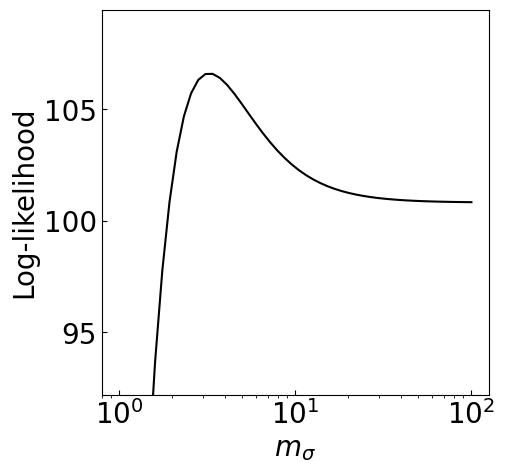

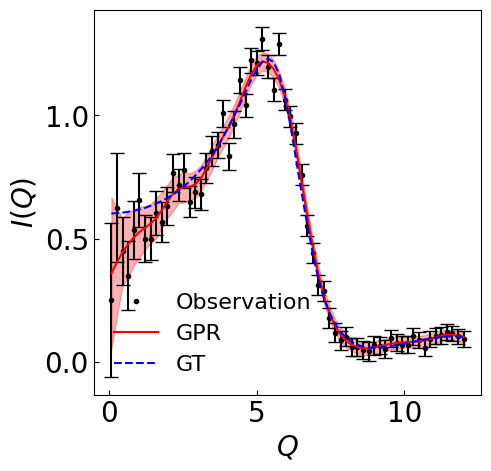

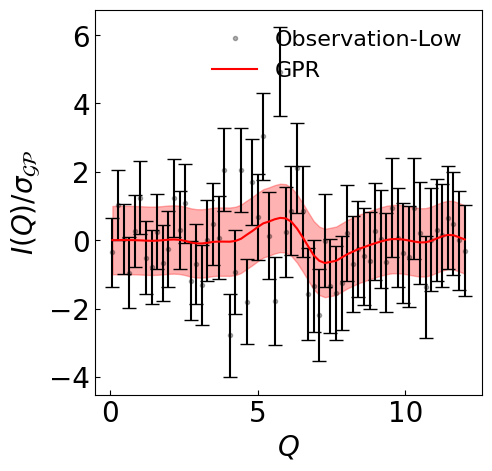

In [9]:
n_trial = 1
n_sample = 5000
dq = q_grid[1] - q_grid[0]
sv_size = 15
gf_size = 2


q_list = []
I_q_gf_list = []
I_q_sv_list = []
I_q_list = []
sum_q_list = []
n_pixels_q_list = []
I_err_list = []

for i in range(n_trial):
    I_q_grid = f_I_q(n_sample, p_qxy) ## count per pixel
    I_q, sum_q, n_pixels_q, I_pixels_q = f_I_q_rad(I_q_grid, q)
    I_q_th, _, _, _ = f_I_q_rad(p_qxy, q)
    I_q_th = I_q_th*n_sample
    I_q_gf = gaussian_filter1d(I_q, gf_size, mode='nearest')
    I_q_sv = savgol_filter(I_q, sv_size, 2, mode='nearest')
    
    I_q_gf_list.append(I_q_gf)
    I_q_sv_list.append(I_q_sv)
    
    I_q_list.append(I_q)
    sum_q_list.append(sum_q)
    n_pixels_q_list.append(n_pixels_q)
    q_list.append(q)
    
    I_err_q = np.sqrt(1/n_pixels_q*[np.sum(I) for I in I_pixels_q]) # var: 1/n_pixels*sum(I)
    I_err_list.append(I_err_q)
    
q_concat = np.concatenate(q_list)
sum_q_concat = np.concatenate(sum_q_list) # sum of total flux at each q bin
n_pixels_q_concat = np.concatenate(n_pixels_q_list) # number of detector pixel at each q bin
I_pixels_q_concat = np.concatenate(I_pixels_q) # list of neutron flux on each pixel at each q bin
I_err_concat = np.concatenate(I_err_list) # accumulated error of neutron flux at each q bin
I_q_gf_concat = np.concatenate(I_q_gf_list)
I_q_sv_concat = np.concatenate(I_q_sv_list)
I_q_concat = np.concatenate(I_q_list)

# average over trials, obtain smoothed I(q) as background
I_q_gf_mean = np.mean(I_q_gf_list, axis=0) # average over smoothed I(q)
I_q_mean_gf = gaussian_filter1d(np.mean(I_q_list, axis=0), gf_size, mode='nearest') # smooth the average I(q)
I_q_gf_mean_concat = np.tile(I_q_gf_mean, n_trial)
I_q_mean_gf_concat = np.tile(I_q_mean_gf, n_trial)

I_q_mean_sv = savgol_filter(np.mean(I_q_list, axis=0), sv_size, 2, mode='nearest') # smooth the average I(q)
I_q_mean_sv_concat = np.tile(I_q_mean_sv, n_trial)
    
# # Plot the radial averaged density for concatenated values
# fig = plt.figure(figsize=(6, 6))
# ax = plt.subplot(1, 1, 1)
# for i, (q, I_q, I_q_gf) in enumerate(zip(q_list, I_q_list, I_q_gf_list)):
#     label_I_q = None
#     label_I_q_gf = None
#     if i == 0:
#         label_I_q = 'I_q'
#         label_I_q_gf = 'I_q_gf'
#     ax.plot(q, I_q, 'ok', label=label_I_q)
#     ax.plot(q, I_q_gf, '-r', label=label_I_q_gf)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.legend(frameon=False)

## GPR
sigma_list = np.logspace(0, 2, 50)
log_likelihood_list = []
for sigma in sigma_list:
    lmbda = 0.5
    # sigma = 10

    ## define kernel function
    y_data = I_q_concat
    y_bg = I_q_mean_gf
    y_bg_concat = I_q_mean_gf_concat
    y_gt = I_q_th
    y = y_data-y_bg

    # y_err = np.sqrt(1/np.maximum(sum_q_concat,np.ones_like(q)))
    y_err = np.sqrt(n_sample/np.sum(n_pixels_q_concat)/np.maximum(n_pixels_q_concat,np.ones_like(q)))
    # y_err = I_err_concat#/np.sqrt(np.maximum(n_pixels_q_concat,np.ones_like(q)))

    # scale by a factor to check whether error estimation is correct
    m_factor = 1
    y_bg = y_bg*m_factor
    y_bg_concat = y_bg_concat*m_factor
    y_gt = y_gt*m_factor
    y = y*m_factor
    y_err = y_err*m_factor
    y_data = y_data*m_factor
    sig_var = np.mean(y**2)

    q_x = q_concat
    q_s = q

    def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
        if std_1 is None:
            std_1 = np.ones_like(q1)
        if std_2 is None:
            std_2 = np.ones_like(q2)
        K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
        return K

    # f_q = lambda q: np.log(q)
    f_q = lambda q: q
    f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
    K_sigma = np.diag(f_y_err(y_err))
    # K_sigma = sigma**2*np.eye(len(q_x))
    K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
    K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
    k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

    L = np.linalg.cholesky(K_xx)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    v = np.linalg.solve(L, K_xs)
    mu_s = K_xs.T @ alpha
    cov_s = k_ss - v.T @ v
    var_s = np.diag(cov_s)*y_err**2
    std_s = np.sqrt(var_s)

    # evaluate the log likelihood
    def f_log_likelihood(y, y_err, mu_s, std_s, importance=np.ones_like(y)):
        ## average over the ovservation uncertainty   
        log_likelihood = 0   
        sum_weight = 0  
        for z in np.linspace(0, 0, 1):
            weight_z = np.exp(-z**2/2)/np.sqrt(2*np.pi)
            y_z = y + y_err*z
            log_likelihood_z = -0.5 * np.sum(((y_z - mu_s)**2 / std_s**2 + np.log(2 * np.pi * std_s**2)))
            log_likelihood += log_likelihood_z*weight_z
            sum_weight += weight_z
        log_likelihood = log_likelihood/sum_weight
        return log_likelihood

    log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
    log_likelihood_list.append(log_likelihood)
    
# plot the log likelihood as a function of sigma
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

ax.plot(sigma_list, log_likelihood_list, '-k')
ax.set_xscale('log')
ax.set_ylim([log_likelihood_list[-1]-(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5,log_likelihood_list[-1]+(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5])
ax.tick_params(direction='in', labelsize=20)
ax.set_xlabel(r'$m_\sigma$', fontsize=20)
ax.set_ylabel(r'Log-likelihood', fontsize=20)

sigma_best = sigma_list[np.argmax(log_likelihood_list)]

# # GPR with best sigma
# f_q = lambda q: np.log(q)
f_q = lambda q: q
f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
K_sigma = np.diag(f_y_err(y_err))
# K_sigma = sigma**2*np.eye(len(q_x))
K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

L = np.linalg.cholesky(K_xx)
alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
v = np.linalg.solve(L, K_xs)
mu_s = K_xs.T @ alpha
cov_s = k_ss - v.T @ v
var_s = np.diag(cov_s)*y_err**2
std_s = np.sqrt(var_s)

# plot the GPR result
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

ax.plot(q_x, y + y_bg_concat, '.k', label='Observation') 
ax.errorbar(q_x, y + y_bg_concat, yerr=y_err, fmt='none', ecolor='k', capsize=5)
ax.plot(q_s, mu_s + y_bg, '-r', label='GPR')
ax.fill_between(q_s, mu_s - std_s + y_bg, mu_s + std_s + y_bg, color='r', alpha=0.3)

ax.plot(q, y_gt , '--b', label='GT')

# ax.plot(q_x, y_bg_concat, '-g')

ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim([1e-2, 1e1])
# ax.set_ylim([-1, 5])

ax.legend(frameon=False, fontsize=16)

# plot the GPR result
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

ax.plot(q_x, y/std_s, '.k', label='Observation-Low', alpha=0.3) 
ax.errorbar(q_x, y/std_s, yerr=y_err/std_s, fmt='none', ecolor='k', capsize=5)

ax.plot(q_s, mu_s/std_s, '-r', label='GPR')
ax.fill_between(q_s, (mu_s - std_s)/std_s, (mu_s + std_s)/std_s, color='r', alpha=0.3)

# ax.plot(q_x, y_bg_concat, '-g')

ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)/\sigma_\mathcal{GP}$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim([1e-2, 1e1])
# ax.set_ylim([-1, 5])

ax.legend(frameon=False, fontsize=16)
# ax.set_xscale('log')
# ax.set_yscale('log')

# Save q_x, y + y_bg_concat, y_err to a file
np.savetxt('Iq_1d.dat', np.c_[q_x, y + y_bg_concat, y_err], header='Q I(Q) Delta I(Q)')

## Animation: Samples from noisy data

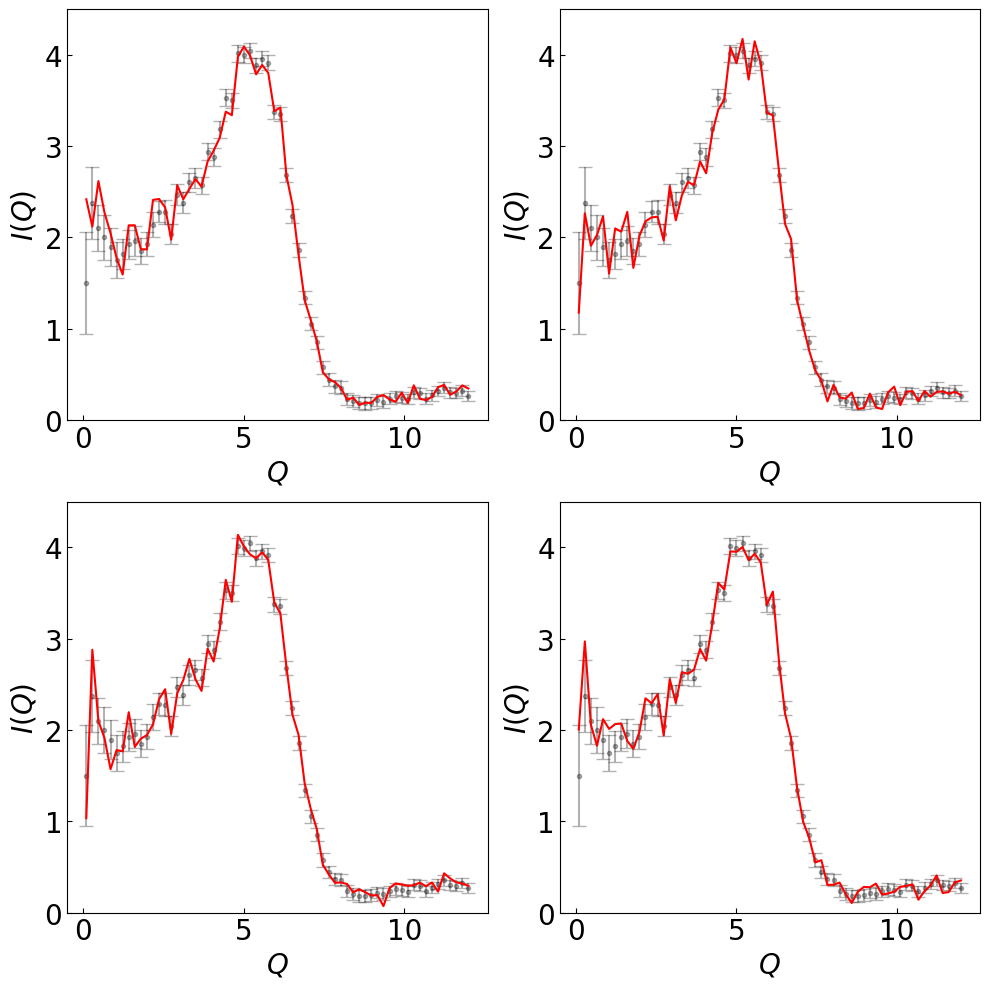

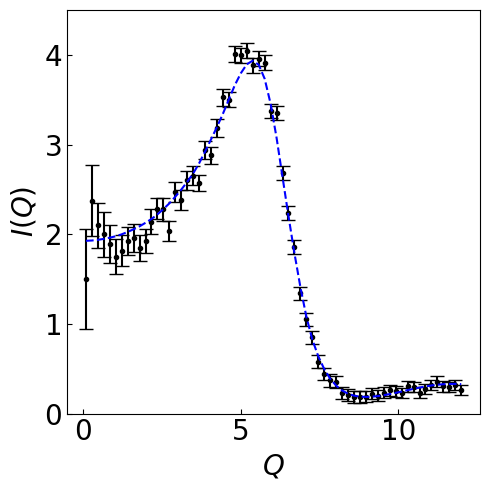

In [6]:
# sample from noisy data
n_curves = 4
I_q_samples = [np.random.normal(loc=y + y_bg, scale=y_err) for _ in range(n_curves)]

fig = plt.figure(figsize=(10, 10))


for i, I_q_sample in enumerate(I_q_samples):
    ax = plt.subplot(2, 2, i+1)

    ax.plot(q_x, y + y_bg, '.k', label='Observation', alpha=0.3) 
    ax.errorbar(q_x, y + y_bg, yerr=y_err, fmt='none', ecolor='k', capsize=5, alpha=0.3)
    
    label = ''
    if i == 0:
        label = 'Sampled'
    ax.plot(q_x, I_q_samples[i], '-r', alpha=1, label=label)

    # ax.plot(q, y_gt , '-b', label='GT')

    ax.set_xlabel(r'$Q$', fontsize=20)
    ax.set_ylabel(r'$I(Q)$', fontsize=20)

    ax.tick_params(direction='in', labelsize=20)
    ax.set_ylim([0, 4.5])
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim([1e-2, 1e1])


# ax.legend(frameon=False, fontsize=16)
plt.tight_layout()

# plot the GPR result
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

ax.plot(q_x, y + y_bg_concat, '.k', label='Observation') 
ax.errorbar(q_x, y + y_bg_concat, yerr=y_err, fmt='none', ecolor='k', capsize=5)
# ax.plot(q_s, mu_s + y_bg, '-r', label='GPR')
# ax.fill_between(q_s, mu_s - std_s + y_bg, mu_s + std_s + y_bg, color='r', alpha=0.3)

ax.plot(q, y_gt , '--b', label='GT')
ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
ax.set_ylim([0, 4.5])
plt.tight_layout()

In [7]:
# sample from noisy data
n_curves = 16
I_q_samples = [np.random.normal(loc=y + y_bg, scale=y_err) for _ in range(n_curves)]

# for i, I_q_sample in enumerate(I_q_samples):
#     fig = plt.figure(figsize=(5, 5))
#     ax = plt.subplot(1, 1, 1)

#     ax.plot(q_x, y + y_bg, '.k', label='Observation', alpha=0.3) 
#     ax.errorbar(q_x, y + y_bg, yerr=y_err, fmt='none', ecolor='k', capsize=5, alpha=0.3)
    
#     label = ''
#     if i == 0:
#         label = 'Sampled'
#     ax.plot(q_x, I_q_samples[i], '-r', alpha=1, label=label)

#     # ax.plot(q, y_gt , '-b', label='GT')

#     ax.set_xlabel(r'$Q$', fontsize=20)
#     ax.set_ylabel(r'$I(Q)$', fontsize=20)

#     ax.tick_params(direction='in', labelsize=20)
#     ax.set_ylim([0, 4.5])
#     # ax.set_xscale('log')
#     # ax.set_yscale('log')
#     # ax.set_ylim([1e-2, 1e1])


#     # ax.legend(frameon=False, fontsize=16)
#     plt.tight_layout()
#     fig.savefig(f'./figures/demo/noisy_sample1d_{i}.png')
    
# make a movie
anim_file = './figures/demo/noisy_sample1d.gif'
import imageio
n_data_list = np.ceil(np.linspace(0,1,65)*len(q)).astype(int)
with imageio.get_writer(anim_file, mode='I', loop=0, duration=1000*8/20) as writer:
    for i, I_q_sample in enumerate(I_q_samples):
        filename = f'./figures/demo/noisy_sample1d_{i}.png'
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


/tmp/ipykernel_2849017/651396969.py:40: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/tmp/ipykernel_2849017/651396969.py:42: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


## Animation: modifying prior by observations

In [8]:
# n_trial = 1
# n_sample = 16000
# dq = q_grid[1] - q_grid[0]
# sv_size = 15
# gf_size = 2


# q_list = []
# I_q_gf_list = []
# I_q_sv_list = []
# I_q_list = []
# sum_q_list = []
# n_pixels_q_list = []
# I_err_list = []

# for i in range(n_trial):
#     I_q_grid = f_I_q(n_sample, p_qxy) ## count per pixel
#     I_q, sum_q, n_pixels_q, I_pixels_q = f_I_q_rad(I_q_grid, q)
#     I_q_th, _, _, _ = f_I_q_rad(p_qxy, q)
#     I_q_th = I_q_th*n_sample
#     I_q_gf = gaussian_filter1d(I_q, gf_size, mode='nearest')
#     I_q_sv = savgol_filter(I_q, sv_size, 2, mode='nearest')
    
#     I_q_gf_list.append(I_q_gf)
#     I_q_sv_list.append(I_q_sv)
    
#     I_q_list.append(I_q)
#     sum_q_list.append(sum_q)
#     n_pixels_q_list.append(n_pixels_q)
#     q_list.append(q)
    
#     I_err_q = np.sqrt(1/n_pixels_q*[np.sum(I) for I in I_pixels_q]) # var: 1/n_pixels*sum(I)
#     I_err_list.append(I_err_q)
    
# q_concat = np.concatenate(q_list)
# sum_q_concat = np.concatenate(sum_q_list) # sum of total flux at each q bin
# n_pixels_q_concat = np.concatenate(n_pixels_q_list) # number of detector pixel at each q bin
# I_pixels_q_concat = np.concatenate(I_pixels_q) # list of neutron flux on each pixel at each q bin
# I_err_concat = np.concatenate(I_err_list) # accumulated error of neutron flux at each q bin
# I_q_gf_concat = np.concatenate(I_q_gf_list)
# I_q_sv_concat = np.concatenate(I_q_sv_list)
# I_q_concat = np.concatenate(I_q_list)

# # average over trials, obtain smoothed I(q) as background
# I_q_gf_mean = np.mean(I_q_gf_list, axis=0) # average over smoothed I(q)
# I_q_mean_gf = gaussian_filter1d(np.mean(I_q_list, axis=0), gf_size, mode='nearest') # smooth the average I(q)
# I_q_gf_mean_concat = np.tile(I_q_gf_mean, n_trial)
# I_q_mean_gf_concat = np.tile(I_q_mean_gf, n_trial)

# I_q_mean_sv = savgol_filter(np.mean(I_q_list, axis=0), sv_size, 2, mode='nearest') # smooth the average I(q)
# I_q_mean_sv_concat = np.tile(I_q_mean_sv, n_trial)
    
# # # Plot the radial averaged density for concatenated values
# # fig = plt.figure(figsize=(6, 6))
# # ax = plt.subplot(1, 1, 1)
# # for i, (q, I_q, I_q_gf) in enumerate(zip(q_list, I_q_list, I_q_gf_list)):
# #     label_I_q = None
# #     label_I_q_gf = None
# #     if i == 0:
# #         label_I_q = 'I_q'
# #         label_I_q_gf = 'I_q_gf'
# #     ax.plot(q, I_q, 'ok', label=label_I_q)
# #     ax.plot(q, I_q_gf, '-r', label=label_I_q_gf)
# # ax.set_xscale('log')
# # ax.set_yscale('log')
# # ax.legend(frameon=False)

# ## GPR
# sigma_list = np.logspace(3,3,1)
# log_likelihood_list = []
# n_data_list = np.ceil(np.linspace(0,1,65)*len(q)).astype(int)
# for n_data in n_data_list:
#     if n_data > 0:
#         lmbda = 0.5
#         sigma = 3

#         ## define kernel function
#         y_data = I_q_concat
#         y_bg = np.mean(I_q_mean_gf)*0
#         y_bg_concat = np.mean(I_q_mean_gf_concat)*0
#         y_gt = I_q_th
#         y = y_data-y_bg

#         # y_err = np.sqrt(1/np.maximum(sum_q_concat,np.ones_like(q)))
#         y_err = np.sqrt(n_sample/np.sum(n_pixels_q_concat)/np.maximum(n_pixels_q_concat,np.ones_like(q)))
#         # y_err = I_err_concat#/np.sqrt(np.maximum(n_pixels_q_concat,np.ones_like(q)))

#         # scale by a factor to check whether error estimation is correct
#         m_factor = 1
#         y_bg = y_bg*m_factor
#         y_bg_concat = y_bg_concat*m_factor
#         y_gt = y_gt*m_factor
#         y = y*m_factor
#         y_err = y_err*m_factor
#         y_data = y_data*m_factor
#         sig_var = np.mean(y**2)

#         q_x = q_concat
#         q_s = q

#         def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
#             if std_1 is None:
#                 std_1 = np.ones_like(q1)
#             if std_2 is None:
#                 std_2 = np.ones_like(q2)
#             K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
#             return K

#         # f_q = lambda q: np.log(q)
#         f_q = lambda q: q
#         f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
#         K_sigma = np.diag(f_y_err(y_err))
#         # K_sigma = sigma**2*np.eye(len(q_x))
#         K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
#         K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
#         k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)
#         K_xx = K_xx[:n_data, :n_data]
#         K_xs = K_xs[:n_data, :]
#         k_ss = k_ss[:, :]

#         L = np.linalg.cholesky(K_xx)
#         alpha = np.linalg.solve(L.T, np.linalg.solve(L, y[:n_data]))
#         v = np.linalg.solve(L, K_xs)
#         mu_s = K_xs.T @ alpha
#         cov_s = k_ss - v.T @ v
#         var_s = np.diag(cov_s)*y_err**2
#         std_s = np.sqrt(var_s)
#     else:
#         mu_s = np.zeros_like(q_s)
#         std_s = np.ones_like(q_s)*y_err

#     # plot the GPR result
#     fig = plt.figure(figsize=(5, 5))
#     ax = plt.subplot(1, 1, 1)

#     ax.plot(q_x[:n_data], (y + y_bg_concat)[:n_data], '.k', label='Observation') 
#     ax.errorbar(q_x[:n_data], (y + y_bg_concat)[:n_data], yerr=y_err[:n_data], fmt='none', ecolor='k', capsize=5)
#     ax.plot(q_x[n_data:], (y + y_bg_concat)[n_data:], '.k', alpha=0.2) 
#     ax.errorbar(q_x[n_data:], (y + y_bg_concat)[n_data:], yerr=y_err[n_data:], fmt='none', ecolor='k', capsize=5, alpha=0.2)
#     ax.plot(q_s, mu_s + y_bg, '-r', label='GPR')
#     ax.fill_between(q_s, mu_s - std_s + y_bg, mu_s + std_s + y_bg, color='r', alpha=0.3)

#     # ax.plot(q, y_gt , '--b', label='GT')

#     # ax.plot(q_x, y_bg_concat, '-g')

#     ax.set_xlabel(r'$Q$', fontsize=20)
#     ax.set_ylabel(r'$I(Q)$', fontsize=20)

#     ax.tick_params(direction='in', labelsize=20)
#     # ax.set_xscale('log')
#     # ax.set_yscale('log')
#     # ax.set_ylim([1e-2, 1e1])
#     ax.set_ylim([-1, 5])

#     # ax.legend(frameon=False, fontsize=16)
#     plt.tight_layout()
#     fig.savefig(f'./figures/demo/GPR_result_{n_data}.png')
    




In [49]:
# n_trial = 1
# n_sample = 16000
# dq = q_grid[1] - q_grid[0]
# sv_size = 15
# gf_size = 2


# q_list = []
# I_q_gf_list = []
# I_q_sv_list = []
# I_q_list = []
# sum_q_list = []
# n_pixels_q_list = []
# I_err_list = []

# for i in range(n_trial):
#     I_q_grid = f_I_q(n_sample, p_qxy) ## count per pixel
#     I_q, sum_q, n_pixels_q, I_pixels_q = f_I_q_rad(I_q_grid, q)
#     I_q_th, _, _, _ = f_I_q_rad(p_qxy, q)
#     I_q_th = I_q_th*n_sample
#     I_q_gf = gaussian_filter1d(I_q, gf_size, mode='nearest')
#     I_q_sv = savgol_filter(I_q, sv_size, 2, mode='nearest')
    
#     I_q_gf_list.append(I_q_gf)
#     I_q_sv_list.append(I_q_sv)
    
#     I_q_list.append(I_q)
#     sum_q_list.append(sum_q)
#     n_pixels_q_list.append(n_pixels_q)
#     q_list.append(q)
    
#     I_err_q = np.sqrt(1/n_pixels_q*[np.sum(I) for I in I_pixels_q]) # var: 1/n_pixels*sum(I)
#     I_err_list.append(I_err_q)
    
# q_concat = np.concatenate(q_list)
# sum_q_concat = np.concatenate(sum_q_list) # sum of total flux at each q bin
# n_pixels_q_concat = np.concatenate(n_pixels_q_list) # number of detector pixel at each q bin
# I_pixels_q_concat = np.concatenate(I_pixels_q) # list of neutron flux on each pixel at each q bin
# I_err_concat = np.concatenate(I_err_list) # accumulated error of neutron flux at each q bin
# I_q_gf_concat = np.concatenate(I_q_gf_list)
# I_q_sv_concat = np.concatenate(I_q_sv_list)
# I_q_concat = np.concatenate(I_q_list)

# # average over trials, obtain smoothed I(q) as background
# I_q_gf_mean = np.mean(I_q_gf_list, axis=0) # average over smoothed I(q)
# I_q_mean_gf = gaussian_filter1d(np.mean(I_q_list, axis=0), gf_size, mode='nearest') # smooth the average I(q)
# I_q_gf_mean_concat = np.tile(I_q_gf_mean, n_trial)
# I_q_mean_gf_concat = np.tile(I_q_mean_gf, n_trial)

# I_q_mean_sv = savgol_filter(np.mean(I_q_list, axis=0), sv_size, 2, mode='nearest') # smooth the average I(q)
# I_q_mean_sv_concat = np.tile(I_q_mean_sv, n_trial)
    
# # # Plot the radial averaged density for concatenated values
# # fig = plt.figure(figsize=(6, 6))
# # ax = plt.subplot(1, 1, 1)
# # for i, (q, I_q, I_q_gf) in enumerate(zip(q_list, I_q_list, I_q_gf_list)):
# #     label_I_q = None
# #     label_I_q_gf = None
# #     if i == 0:
# #         label_I_q = 'I_q'
# #         label_I_q_gf = 'I_q_gf'
# #     ax.plot(q, I_q, 'ok', label=label_I_q)
# #     ax.plot(q, I_q_gf, '-r', label=label_I_q_gf)
# # ax.set_xscale('log')
# # ax.set_yscale('log')
# # ax.legend(frameon=False)

# ## GPR
# sigma_list = np.logspace(3,3,1)
# log_likelihood_list = []
# n_data_list = np.ceil(np.linspace(0,1,65)*len(q)).astype(int)
# index_data_all = np.arange(len(q))
# np.random.shuffle(index_data_all)

# for n_data in n_data_list:
#     if n_data > 0:
#         lmbda = 0.5
#         sigma = 3
        
#         index_data = np.sort(index_data_all[:n_data])

#         ## define kernel function
#         y_data = I_q_concat
#         y_bg = np.mean(I_q_mean_gf)*0
#         y_bg_concat = np.mean(I_q_mean_gf_concat)*0
#         y_gt = I_q_th
#         y = y_data-y_bg

#         # y_err = np.sqrt(1/np.maximum(sum_q_concat,np.ones_like(q)))
#         y_err = np.sqrt(n_sample/np.sum(n_pixels_q_concat)/np.maximum(n_pixels_q_concat,np.ones_like(q)))
#         # y_err = I_err_concat#/np.sqrt(np.maximum(n_pixels_q_concat,np.ones_like(q)))

#         # scale by a factor to check whether error estimation is correct
#         m_factor = 1
#         y_bg = y_bg*m_factor
#         y_bg_concat = y_bg_concat*m_factor
#         y_gt = y_gt*m_factor
#         y = y*m_factor
#         y_err = y_err*m_factor
#         y_data = y_data*m_factor
#         sig_var = np.mean(y**2)

#         q_x = q_concat
#         q_s = q

#         def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
#             if std_1 is None:
#                 std_1 = np.ones_like(q1)
#             if std_2 is None:
#                 std_2 = np.ones_like(q2)
#             K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
#             return K

#         # f_q = lambda q: np.log(q)
#         f_q = lambda q: q
#         f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
#         K_sigma = np.diag(f_y_err(y_err))
#         # K_sigma = sigma**2*np.eye(len(q_x))
#         K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
#         K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
#         k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)
#         K_xx = K_xx[index_data, :][:, index_data]
#         K_xs = K_xs[index_data, :]
#         k_ss = k_ss[:, :]

#         L = np.linalg.cholesky(K_xx)
#         alpha = np.linalg.solve(L.T, np.linalg.solve(L, y[index_data]))
#         v = np.linalg.solve(L, K_xs)
#         mu_s = K_xs.T @ alpha
#         cov_s = k_ss - v.T @ v
#         var_s = np.diag(cov_s)*y_err**2
#         std_s = np.sqrt(var_s)
#     else:
#         mu_s = np.zeros_like(q_s)
#         std_s = np.ones_like(q_s)*y_err

#     # plot the GPR result
#     fig = plt.figure(figsize=(5, 5))
#     ax = plt.subplot(1, 1, 1)

#     ax.plot(q_x[index_data], (y + y_bg_concat)[index_data], '.k', label='Observation') 
#     ax.errorbar(q_x[index_data], (y + y_bg_concat)[index_data], yerr=y_err[index_data], fmt='none', ecolor='k', capsize=5)
#     index_excluded = np.setdiff1d(index_data_all, index_data)
#     ax.plot(q_x[index_excluded], (y + y_bg_concat)[index_excluded], '.k', alpha=0.2) 
#     ax.errorbar(q_x[index_excluded], (y + y_bg_concat)[index_excluded], yerr=y_err[index_excluded], fmt='none', ecolor='k', capsize=5, alpha=0.2)
    
#     ax.plot(q_s, mu_s + y_bg, '-r', label='GPR')
#     ax.fill_between(q_s, mu_s - std_s + y_bg, mu_s + std_s + y_bg, color='r', alpha=0.3)

#     # ax.plot(q, y_gt , '--b', label='GT')

#     # ax.plot(q_x, y_bg_concat, '-g')

#     ax.set_xlabel(r'$Q$', fontsize=20)
#     ax.set_ylabel(r'$I(Q)$', fontsize=20)

#     ax.tick_params(direction='in', labelsize=20)
#     # ax.set_xscale('log')
#     # ax.set_yscale('log')
#     # ax.set_ylim([1e-2, 1e1])
#     ax.set_ylim([-1, 5])

#     # ax.legend(frameon=False, fontsize=16)
#     plt.tight_layout()
#     fig.savefig(f'./figures/demo/GPR_result_{n_data}.png')
    




In [45]:
# make a movie
anim_file = './figures/demo/add_obs_rand.gif'
import imageio
n_data_list = np.ceil(np.linspace(0,1,65)*len(q)).astype(int)
with imageio.get_writer(anim_file, mode='I', loop=0, duration=1000*8/80) as writer:
    for n_data in n_data_list:
        filename = f'./figures/demo/GPR_result_{n_data}.png'
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


/tmp/ipykernel_2849017/246899859.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/tmp/ipykernel_2849017/246899859.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


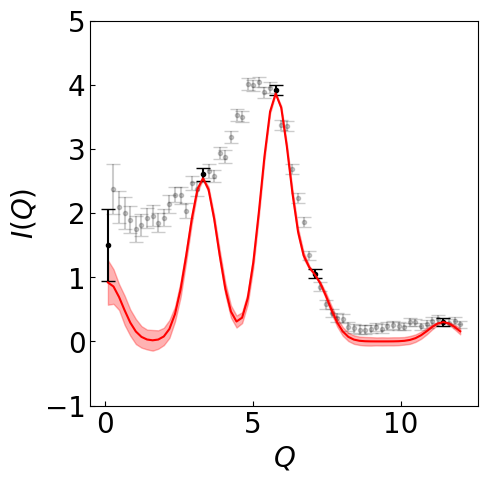

In [11]:
n_trial = 1
n_sample = 16000
dq = q_grid[1] - q_grid[0]
sv_size = 15
gf_size = 2


q_list = []
I_q_gf_list = []
I_q_sv_list = []
I_q_list = []
sum_q_list = []
n_pixels_q_list = []
I_err_list = []

for i in range(n_trial):
    I_q_grid = f_I_q(n_sample, p_qxy) ## count per pixel
    I_q, sum_q, n_pixels_q, I_pixels_q = f_I_q_rad(I_q_grid, q)
    I_q_th, _, _, _ = f_I_q_rad(p_qxy, q)
    I_q_th = I_q_th*n_sample
    I_q_gf = gaussian_filter1d(I_q, gf_size, mode='nearest')
    I_q_sv = savgol_filter(I_q, sv_size, 2, mode='nearest')
    
    I_q_gf_list.append(I_q_gf)
    I_q_sv_list.append(I_q_sv)
    
    I_q_list.append(I_q)
    sum_q_list.append(sum_q)
    n_pixels_q_list.append(n_pixels_q)
    q_list.append(q)
    
    I_err_q = np.sqrt(1/n_pixels_q*[np.sum(I) for I in I_pixels_q]) # var: 1/n_pixels*sum(I)
    I_err_list.append(I_err_q)
    
q_concat = np.concatenate(q_list)
sum_q_concat = np.concatenate(sum_q_list) # sum of total flux at each q bin
n_pixels_q_concat = np.concatenate(n_pixels_q_list) # number of detector pixel at each q bin
I_pixels_q_concat = np.concatenate(I_pixels_q) # list of neutron flux on each pixel at each q bin
I_err_concat = np.concatenate(I_err_list) # accumulated error of neutron flux at each q bin
I_q_gf_concat = np.concatenate(I_q_gf_list)
I_q_sv_concat = np.concatenate(I_q_sv_list)
I_q_concat = np.concatenate(I_q_list)

# average over trials, obtain smoothed I(q) as background
I_q_gf_mean = np.mean(I_q_gf_list, axis=0) # average over smoothed I(q)
I_q_mean_gf = gaussian_filter1d(np.mean(I_q_list, axis=0), gf_size, mode='nearest') # smooth the average I(q)
I_q_gf_mean_concat = np.tile(I_q_gf_mean, n_trial)
I_q_mean_gf_concat = np.tile(I_q_mean_gf, n_trial)

I_q_mean_sv = savgol_filter(np.mean(I_q_list, axis=0), sv_size, 2, mode='nearest') # smooth the average I(q)
I_q_mean_sv_concat = np.tile(I_q_mean_sv, n_trial)
    
# # Plot the radial averaged density for concatenated values
# fig = plt.figure(figsize=(6, 6))
# ax = plt.subplot(1, 1, 1)
# for i, (q, I_q, I_q_gf) in enumerate(zip(q_list, I_q_list, I_q_gf_list)):
#     label_I_q = None
#     label_I_q_gf = None
#     if i == 0:
#         label_I_q = 'I_q'
#         label_I_q_gf = 'I_q_gf'
#     ax.plot(q, I_q, 'ok', label=label_I_q)
#     ax.plot(q, I_q_gf, '-r', label=label_I_q_gf)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.legend(frameon=False)

## GPR
sigma_list = np.logspace(3,3,1)
log_likelihood_list = []
n_data_list = np.ceil(np.linspace(0,1,65)*len(q)).astype(int)
index_data_all = np.arange(len(q))
np.random.shuffle(index_data_all)

fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

for n_data in n_data_list[[5]]:
    if n_data > 0:
        lmbda = 0.5
        sigma = 3
        
        index_data = np.sort(index_data_all[:n_data])

        ## define kernel function
        y_data = I_q_concat
        y_bg = np.mean(I_q_mean_gf)*0
        y_bg_concat = np.mean(I_q_mean_gf_concat)*0
        y_gt = I_q_th
        y = y_data-y_bg

        # y_err = np.sqrt(1/np.maximum(sum_q_concat,np.ones_like(q)))
        y_err = np.sqrt(n_sample/np.sum(n_pixels_q_concat)/np.maximum(n_pixels_q_concat,np.ones_like(q)))
        # y_err = I_err_concat#/np.sqrt(np.maximum(n_pixels_q_concat,np.ones_like(q)))

        # scale by a factor to check whether error estimation is correct
        m_factor = 1
        y_bg = y_bg*m_factor
        y_bg_concat = y_bg_concat*m_factor
        y_gt = y_gt*m_factor
        y = y*m_factor
        y_err = y_err*m_factor
        y_data = y_data*m_factor
        sig_var = np.mean(y**2)

        q_x = q_concat
        q_s = q

        def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
            if std_1 is None:
                std_1 = np.ones_like(q1)
            if std_2 is None:
                std_2 = np.ones_like(q2)
            K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
            return K

        # f_q = lambda q: np.log(q)
        f_q = lambda q: q
        f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
        k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)
        K_xx = K_xx[index_data, :][:, index_data]
        K_xs = K_xs[index_data, :]
        k_ss = k_ss[:, :]

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y[index_data]))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*y_err**2
        std_s = np.sqrt(var_s)
    else:
        lmbda = 0.5
        sigma = 3
        
        index_data = np.sort(index_data_all[:n_data])

        ## define kernel function
        y_data = I_q_concat
        y_bg = np.mean(I_q_mean_gf)*0
        y_bg_concat = np.mean(I_q_mean_gf_concat)*0
        y_gt = I_q_th
        y = y_data-y_bg

        # y_err = np.sqrt(1/np.maximum(sum_q_concat,np.ones_like(q)))
        y_err = np.sqrt(n_sample/np.sum(n_pixels_q_concat)/np.maximum(n_pixels_q_concat,np.ones_like(q)))
        # y_err = I_err_concat#/np.sqrt(np.maximum(n_pixels_q_concat,np.ones_like(q)))

        # scale by a factor to check whether error estimation is correct
        m_factor = 1
        y_bg = y_bg*m_factor
        y_bg_concat = y_bg_concat*m_factor
        y_gt = y_gt*m_factor
        y = y*m_factor
        y_err = y_err*m_factor
        y_data = y_data*m_factor
        sig_var = np.mean(y**2)

        q_x = q_concat
        q_s = q
        y_err = np.sqrt(n_sample/np.sum(n_pixels_q_concat)/np.maximum(n_pixels_q_concat,np.ones_like(q)))
        mu_s = np.zeros_like(q_s)
        std_s = np.ones_like(q_s)*y_err

    # plot the GPR result

    ax.plot(q_x[index_data], (y + y_bg_concat)[index_data], '.k', label='Observation') 
    ax.errorbar(q_x[index_data], (y + y_bg_concat)[index_data], yerr=y_err[index_data], fmt='none', ecolor='k', capsize=5)
    index_excluded = np.setdiff1d(index_data_all, index_data)
    ax.plot(q_x[index_excluded], (y + y_bg_concat)[index_excluded], '.k', alpha=0.2) 
    ax.errorbar(q_x[index_excluded], (y + y_bg_concat)[index_excluded], yerr=y_err[index_excluded], fmt='none', ecolor='k', capsize=5, alpha=0.2)
    
    ax.plot(q_s, mu_s + y_bg, '-r', label='GPR')
    ax.fill_between(q_s, mu_s - std_s + y_bg, mu_s + std_s + y_bg, color='r', alpha=0.3)

    # ax.plot(q, y_gt , '--b', label='GT')

    # ax.plot(q_x, y_bg_concat, '-g')

    ax.set_xlabel(r'$Q$', fontsize=20)
    ax.set_ylabel(r'$I(Q)$', fontsize=20)

    ax.tick_params(direction='in', labelsize=20)
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    # ax.set_ylim([1e-2, 1e1])
    ax.set_ylim([-1, 5])

    




## Animation: data quality

In [10]:
1.25**np.arange(15)

array([ 1.        ,  1.25      ,  1.5625    ,  1.953125  ,  2.44140625,
        3.05175781,  3.81469727,  4.76837158,  5.96046448,  7.4505806 ,
        9.31322575, 11.64153218, 14.55191523, 18.18989404, 22.73736754])

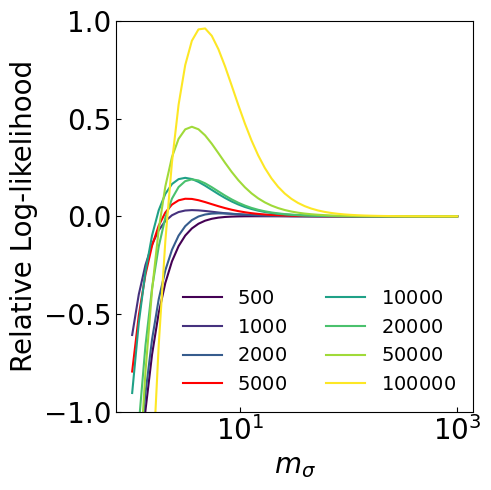

In [19]:
n_trial = 1
# plot the log likelihood as a function of sigma
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

# n_sample_list = [1000, 1250, 1600, 2000, 2500, 3000, 3800, 4800, 5000, 7500, 10000, 12500, 16000, 20000, 25000, 30000, 38000, 48000, 50000, 75000, 100000]
n_sample_list = [500, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
# n_sample_list = np.linspace(1000, 20000, 10)
for i_n, n_sample in enumerate(n_sample_list):
    n_sample = int(n_sample)
    color = get_viridis_color(i_n/(len(n_sample_list)-1))
    
    dq = q_grid[1] - q_grid[0]
    sv_size = 15
    gf_size = 2


    q_list = []
    I_q_gf_list = []
    I_q_sv_list = []
    I_q_list = []
    sum_q_list = []
    n_pixels_q_list = []
    I_err_list = []

    for i in range(n_trial):
        I_q_grid = f_I_q(n_sample, p_qxy) ## count per pixel
        I_q, sum_q, n_pixels_q, I_pixels_q = f_I_q_rad(I_q_grid, q)
        I_q_th, _, _, _ = f_I_q_rad(p_qxy, q)
        I_q_th = I_q_th*n_sample
        I_q_gf = gaussian_filter1d(I_q, gf_size, mode='nearest')
        I_q_sv = savgol_filter(I_q, sv_size, 2, mode='nearest')
        
        I_q_gf_list.append(I_q_gf)
        I_q_sv_list.append(I_q_sv)
        
        I_q_list.append(I_q)
        sum_q_list.append(sum_q)
        n_pixels_q_list.append(n_pixels_q)
        q_list.append(q)
        
        I_err_q = np.sqrt(1/n_pixels_q*[np.sum(I) for I in I_pixels_q]) # var: 1/n_pixels*sum(I)
        I_err_list.append(I_err_q)
        
    q_concat = np.concatenate(q_list)
    sum_q_concat = np.concatenate(sum_q_list) # sum of total flux at each q bin
    n_pixels_q_concat = np.concatenate(n_pixels_q_list) # number of detector pixel at each q bin
    I_pixels_q_concat = np.concatenate(I_pixels_q) # list of neutron flux on each pixel at each q bin
    I_err_concat = np.concatenate(I_err_list) # accumulated error of neutron flux at each q bin
    I_q_gf_concat = np.concatenate(I_q_gf_list)
    I_q_sv_concat = np.concatenate(I_q_sv_list)
    I_q_concat = np.concatenate(I_q_list)

    # average over trials, obtain smoothed I(q) as background
    I_q_gf_mean = np.mean(I_q_gf_list, axis=0) # average over smoothed I(q)
    I_q_mean_gf = gaussian_filter1d(np.mean(I_q_list, axis=0), gf_size, mode='nearest') # smooth the average I(q)
    I_q_gf_mean_concat = np.tile(I_q_gf_mean, n_trial)
    I_q_mean_gf_concat = np.tile(I_q_mean_gf, n_trial)

    I_q_mean_sv = savgol_filter(np.mean(I_q_list, axis=0), sv_size, 2, mode='nearest') # smooth the average I(q)
    I_q_mean_sv_concat = np.tile(I_q_mean_sv, n_trial)
        
    # # Plot the radial averaged density for concatenated values
    # fig = plt.figure(figsize=(6, 6))
    # ax = plt.subplot(1, 1, 1)
    # for i, (q, I_q, I_q_gf) in enumerate(zip(q_list, I_q_list, I_q_gf_list)):
    #     label_I_q = None
    #     label_I_q_gf = None
    #     if i == 0:
    #         label_I_q = 'I_q'
    #         label_I_q_gf = 'I_q_gf'
    #     ax.plot(q, I_q, 'ok', label=label_I_q)
    #     ax.plot(q, I_q_gf, '-r', label=label_I_q_gf)
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    # ax.legend(frameon=False)

    ## GPR
    sigma_list = np.logspace(0, 3, 50)
    log_likelihood_list = []
    for sigma in sigma_list:
        lmbda = 0.5
        # sigma = 10

        ## define kernel function
        y_data = I_q_concat
        y_bg = I_q_mean_gf
        y_bg_concat = I_q_mean_gf_concat
        y_gt = I_q_th
        y = y_data-y_bg

        # y_err = np.sqrt(1/np.maximum(sum_q_concat,np.ones_like(q)))
        y_err = np.sqrt(n_sample/np.sum(n_pixels_q_concat)/np.maximum(n_pixels_q_concat,np.ones_like(q)))
        # y_err = I_err_concat#/np.sqrt(np.maximum(n_pixels_q_concat,np.ones_like(q)))

        # scale by a factor to check whether error estimation is correct
        m_factor = 1
        y_bg = y_bg*m_factor
        y_bg_concat = y_bg_concat*m_factor
        y_gt = y_gt*m_factor
        y = y*m_factor
        y_err = y_err*m_factor
        y_data = y_data*m_factor
        sig_var = np.mean(y**2)

        q_x = q_concat
        q_s = q

        def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
            if std_1 is None:
                std_1 = np.ones_like(q1)
            if std_2 is None:
                std_2 = np.ones_like(q2)
            K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
            return K

        # f_q = lambda q: np.log(q)
        f_q = lambda q: q
        f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
        k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*y_err**2
        std_s = np.sqrt(var_s)

        # evaluate the log likelihood
        def f_log_likelihood(y, y_err, mu_s, std_s, importance=np.ones_like(y)):
            ## average over the ovservation uncertainty   
            log_likelihood = 0   
            sum_weight = 0  
            for z in np.linspace(0, 0, 1):
                weight_z = np.exp(-z**2/2)/np.sqrt(2*np.pi)
                y_z = y + y_err*z
                log_likelihood_z = -0.5 * np.sum(((y_z - mu_s)**2 / std_s**2 + np.log(2 * np.pi * std_s**2)))
                log_likelihood += log_likelihood_z*weight_z
                sum_weight += weight_z
            log_likelihood = log_likelihood/sum_weight
            return log_likelihood

        log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
        log_likelihood_list.append(log_likelihood)
        
    log_likelihood_list = np.array(log_likelihood_list)
    log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

    if n_sample == 5000:
        color = 'r'
    ax.plot(sigma_list, log_likelihood_list, '-', color=color, label=f'${n_sample}$')
    ax.set_xscale('log')
    # ax.set_ylim([log_likelihood_list[-1]-(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5,log_likelihood_list[-1]+(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5])
    ax.set_ylim([-1, 1])
    ax.tick_params(direction='in', labelsize=20)
    ax.set_xlabel(r'$m_\sigma$', fontsize=20)
    ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

    sigma_best = sigma_list[np.argmax(log_likelihood_list)]
    
ax.legend(frameon=False, fontsize=14, ncol=2)
plt.tight_layout()

# # # GPR with best sigma
# # f_q = lambda q: np.log(q)
# f_q = lambda q: q
# f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
# K_sigma = np.diag(f_y_err(y_err))
# # K_sigma = sigma**2*np.eye(len(q_x))
# K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
# K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
# k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

# L = np.linalg.cholesky(K_xx)
# alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
# v = np.linalg.solve(L, K_xs)
# mu_s = K_xs.T @ alpha
# cov_s = k_ss - v.T @ v
# var_s = np.diag(cov_s)*y_err**2
# std_s = np.sqrt(var_s)



/tmp/ipykernel_2849017/2997161134.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(5, 5))


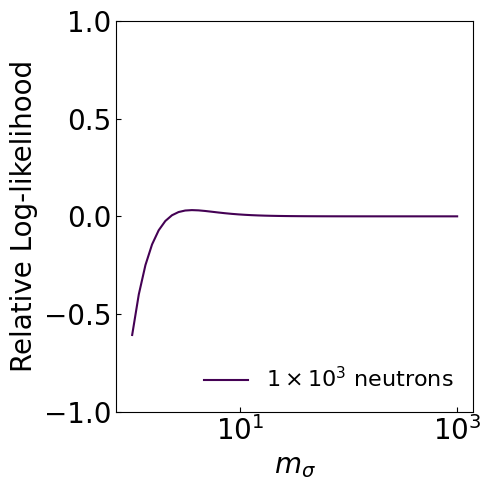

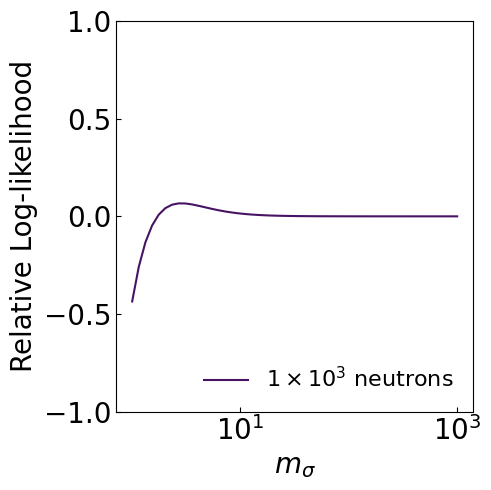

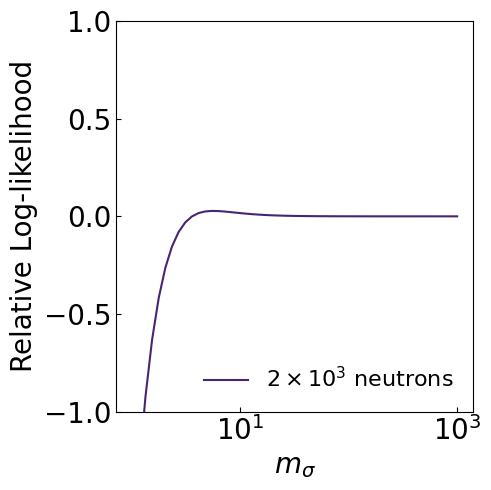

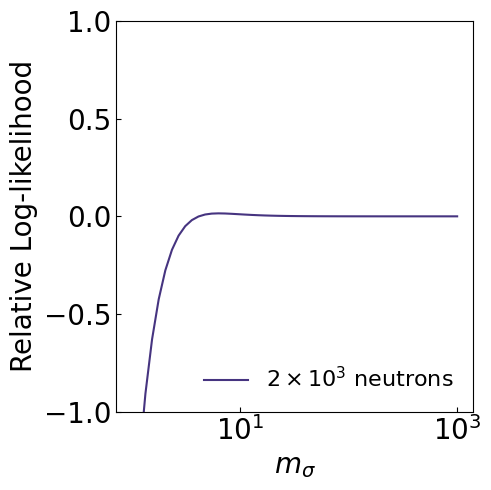

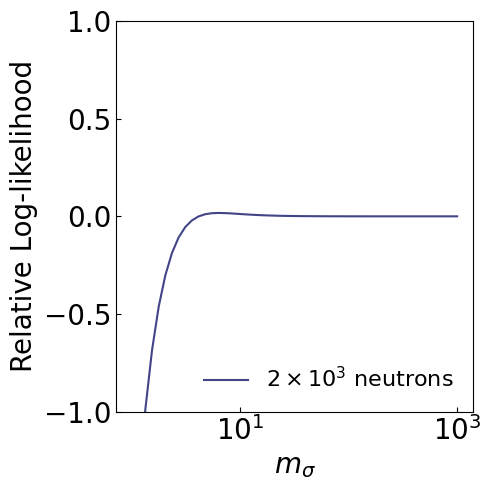

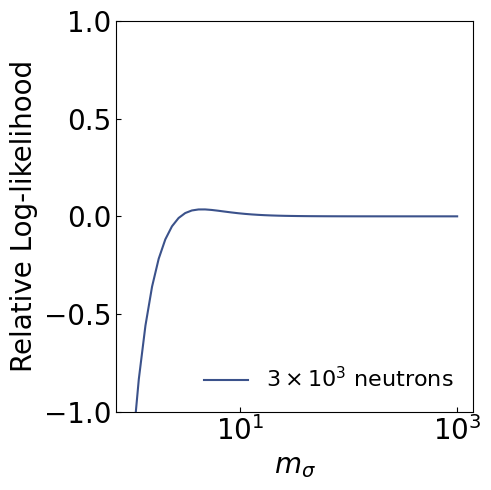

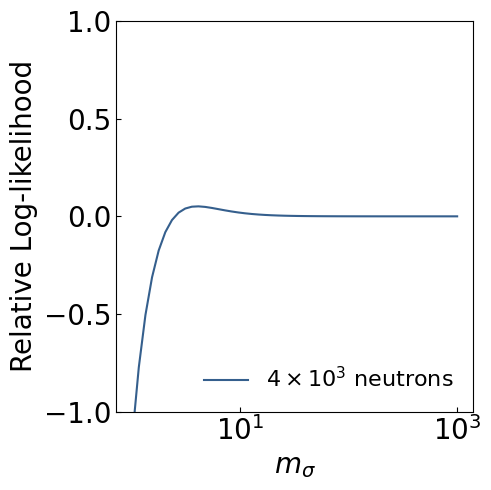

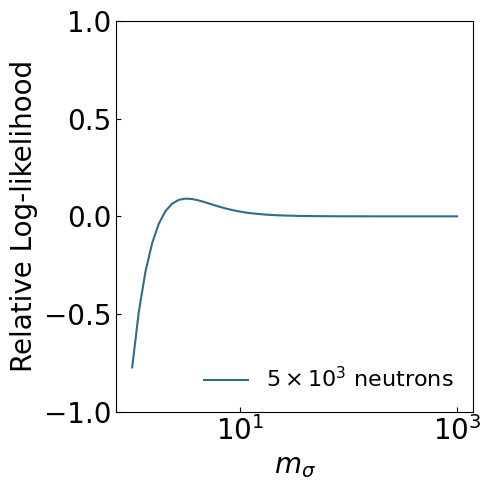

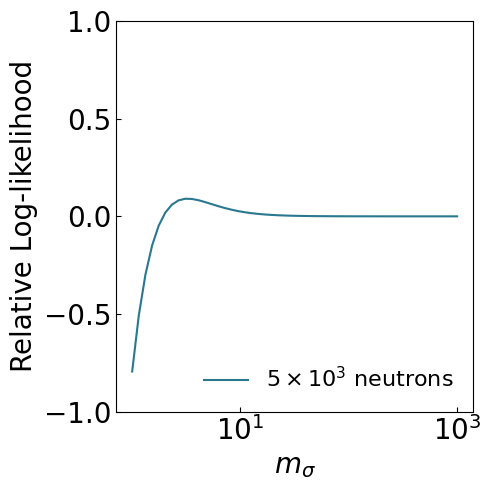

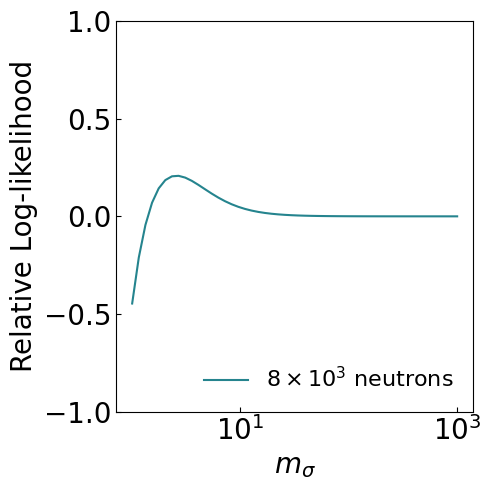

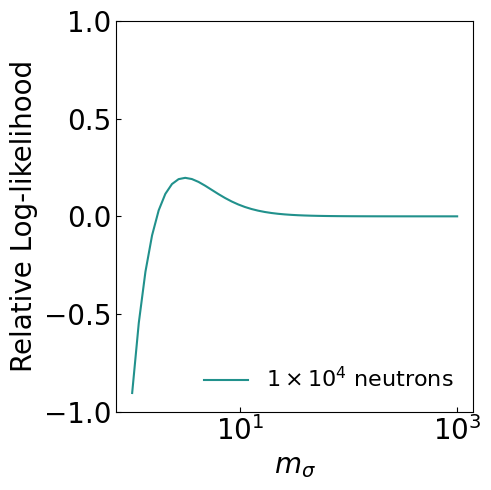

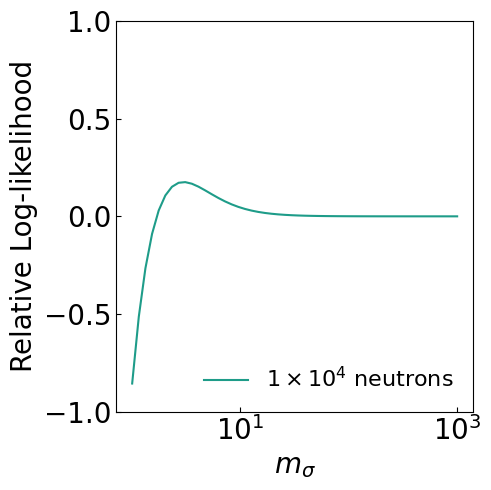

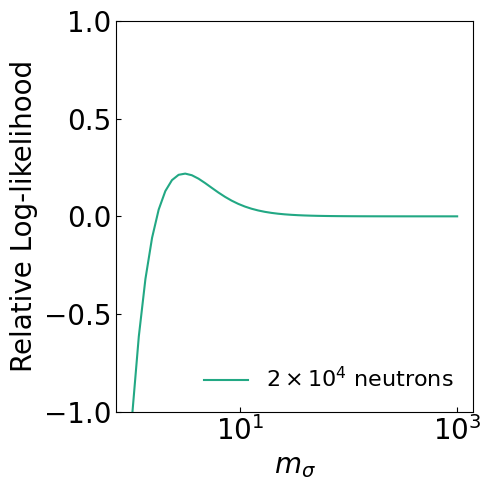

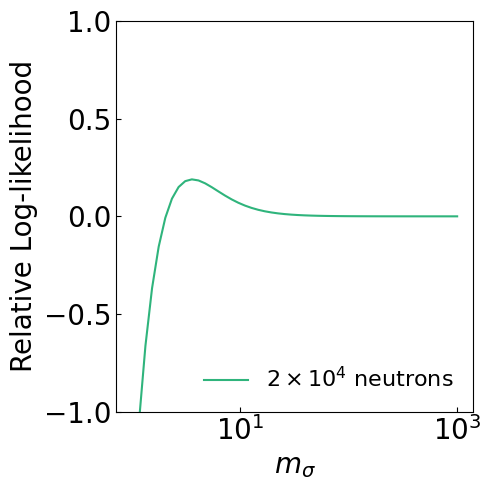

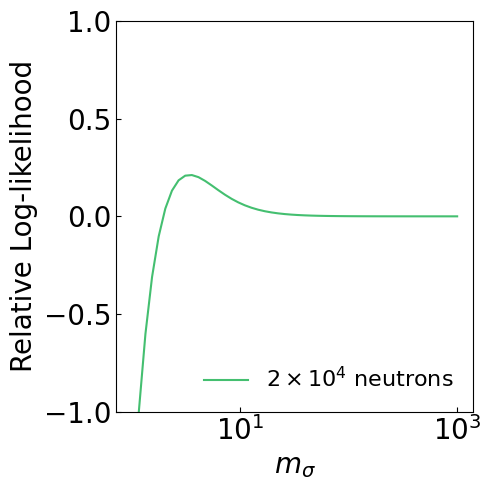

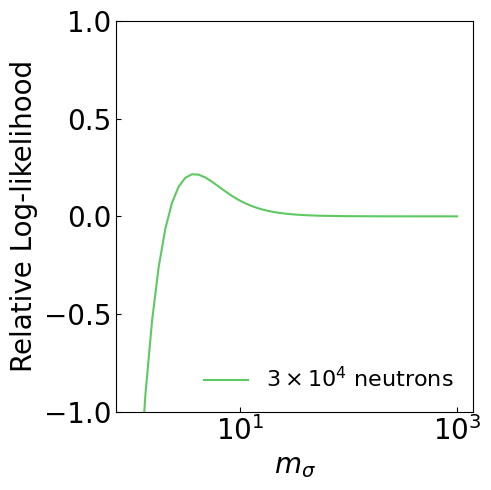

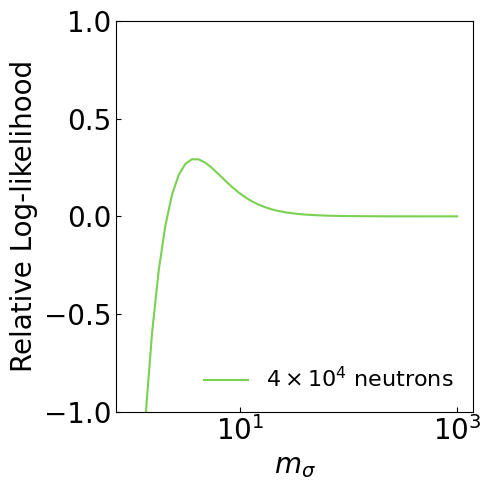

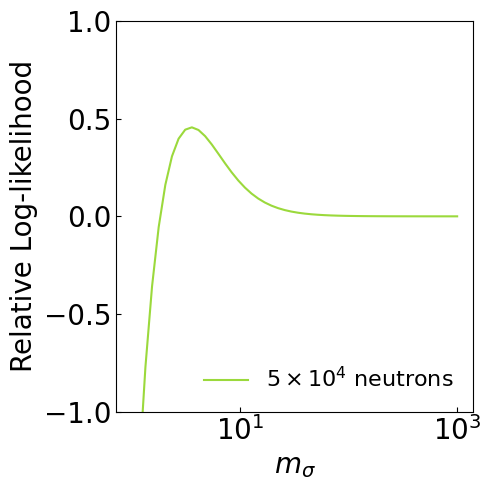

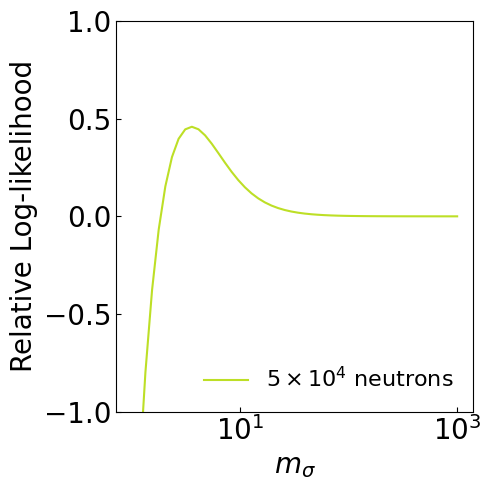

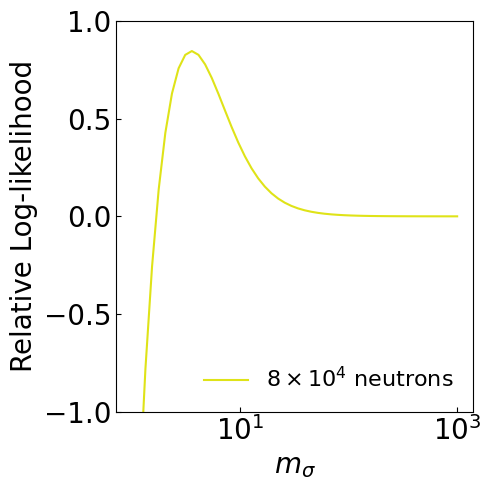

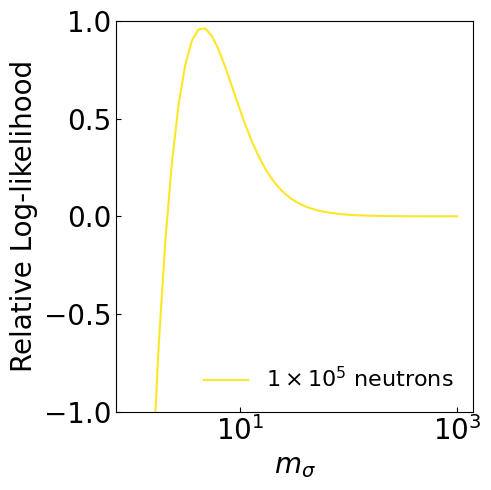

In [24]:
n_trial = 1
# plot the log likelihood as a function of sigma
def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

n_sample_list = [1000, 1250, 1600, 2000, 2500, 3000, 3800, 4800, 5000, 7500, 10000, 12500, 16000, 20000, 25000, 30000, 38000, 48000, 50000, 75000, 100000]
# n_sample_list = [500, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
# n_sample_list = np.linspace(1000, 20000, 10)
for i_n, n_sample in enumerate(n_sample_list):
    fig = plt.figure(figsize=(5, 5))
    ax = plt.subplot(1, 1, 1)
    
    n_sample = int(n_sample)
    color = get_viridis_color(i_n/(len(n_sample_list)-1))
    
    dq = q_grid[1] - q_grid[0]
    sv_size = 15
    gf_size = 2


    q_list = []
    I_q_gf_list = []
    I_q_sv_list = []
    I_q_list = []
    sum_q_list = []
    n_pixels_q_list = []
    I_err_list = []

    for i in range(n_trial):
        I_q_grid = f_I_q(n_sample, p_qxy) ## count per pixel
        I_q, sum_q, n_pixels_q, I_pixels_q = f_I_q_rad(I_q_grid, q)
        I_q_th, _, _, _ = f_I_q_rad(p_qxy, q)
        I_q_th = I_q_th*n_sample
        I_q_gf = gaussian_filter1d(I_q, gf_size, mode='nearest')
        I_q_sv = savgol_filter(I_q, sv_size, 2, mode='nearest')
        
        I_q_gf_list.append(I_q_gf)
        I_q_sv_list.append(I_q_sv)
        
        I_q_list.append(I_q)
        sum_q_list.append(sum_q)
        n_pixels_q_list.append(n_pixels_q)
        q_list.append(q)
        
        I_err_q = np.sqrt(1/n_pixels_q*[np.sum(I) for I in I_pixels_q]) # var: 1/n_pixels*sum(I)
        I_err_list.append(I_err_q)
        
    q_concat = np.concatenate(q_list)
    sum_q_concat = np.concatenate(sum_q_list) # sum of total flux at each q bin
    n_pixels_q_concat = np.concatenate(n_pixels_q_list) # number of detector pixel at each q bin
    I_pixels_q_concat = np.concatenate(I_pixels_q) # list of neutron flux on each pixel at each q bin
    I_err_concat = np.concatenate(I_err_list) # accumulated error of neutron flux at each q bin
    I_q_gf_concat = np.concatenate(I_q_gf_list)
    I_q_sv_concat = np.concatenate(I_q_sv_list)
    I_q_concat = np.concatenate(I_q_list)

    # average over trials, obtain smoothed I(q) as background
    I_q_gf_mean = np.mean(I_q_gf_list, axis=0) # average over smoothed I(q)
    I_q_mean_gf = gaussian_filter1d(np.mean(I_q_list, axis=0), gf_size, mode='nearest') # smooth the average I(q)
    I_q_gf_mean_concat = np.tile(I_q_gf_mean, n_trial)
    I_q_mean_gf_concat = np.tile(I_q_mean_gf, n_trial)

    I_q_mean_sv = savgol_filter(np.mean(I_q_list, axis=0), sv_size, 2, mode='nearest') # smooth the average I(q)
    I_q_mean_sv_concat = np.tile(I_q_mean_sv, n_trial)
        
    # # Plot the radial averaged density for concatenated values
    # fig = plt.figure(figsize=(6, 6))
    # ax = plt.subplot(1, 1, 1)
    # for i, (q, I_q, I_q_gf) in enumerate(zip(q_list, I_q_list, I_q_gf_list)):
    #     label_I_q = None
    #     label_I_q_gf = None
    #     if i == 0:
    #         label_I_q = 'I_q'
    #         label_I_q_gf = 'I_q_gf'
    #     ax.plot(q, I_q, 'ok', label=label_I_q)
    #     ax.plot(q, I_q_gf, '-r', label=label_I_q_gf)
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    # ax.legend(frameon=False)

    ## GPR
    sigma_list = np.logspace(0, 3, 50)
    log_likelihood_list = []
    for sigma in sigma_list:
        lmbda = 0.5
        # sigma = 10

        ## define kernel function
        y_data = I_q_concat
        y_bg = I_q_mean_gf
        y_bg_concat = I_q_mean_gf_concat
        y_gt = I_q_th
        y = y_data-y_bg

        # y_err = np.sqrt(1/np.maximum(sum_q_concat,np.ones_like(q)))
        y_err = np.sqrt(n_sample/np.sum(n_pixels_q_concat)/np.maximum(n_pixels_q_concat,np.ones_like(q)))
        # y_err = I_err_concat#/np.sqrt(np.maximum(n_pixels_q_concat,np.ones_like(q)))

        # scale by a factor to check whether error estimation is correct
        m_factor = 1
        y_bg = y_bg*m_factor
        y_bg_concat = y_bg_concat*m_factor
        y_gt = y_gt*m_factor
        y = y*m_factor
        y_err = y_err*m_factor
        y_data = y_data*m_factor
        sig_var = np.mean(y**2)

        q_x = q_concat
        q_s = q

        def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
            if std_1 is None:
                std_1 = np.ones_like(q1)
            if std_2 is None:
                std_2 = np.ones_like(q2)
            K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
            return K

        # f_q = lambda q: np.log(q)
        f_q = lambda q: q
        f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
        k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*y_err**2
        std_s = np.sqrt(var_s)

        # evaluate the log likelihood
        def f_log_likelihood(y, y_err, mu_s, std_s, importance=np.ones_like(y)):
            ## average over the ovservation uncertainty   
            log_likelihood = 0   
            sum_weight = 0  
            for z in np.linspace(0, 0, 1):
                weight_z = np.exp(-z**2/2)/np.sqrt(2*np.pi)
                y_z = y + y_err*z
                log_likelihood_z = -0.5 * np.sum(((y_z - mu_s)**2 / std_s**2 + np.log(2 * np.pi * std_s**2)))
                log_likelihood += log_likelihood_z*weight_z
                sum_weight += weight_z
            log_likelihood = log_likelihood/sum_weight
            return log_likelihood

        log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
        log_likelihood_list.append(log_likelihood)
        
    log_likelihood_list = np.array(log_likelihood_list)
    log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

    # if n_sample == 5000:
    #     color = 'r'
    ax.plot(sigma_list, log_likelihood_list, '-', color=color, label=f'${n_sample:.0e}$ neutrons'.replace('e+0', r'\times 10^'))
    ax.set_xscale('log')
    # ax.set_ylim([log_likelihood_list[-1]-(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5,log_likelihood_list[-1]+(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5])
    ax.set_ylim([-1, 1])
    ax.tick_params(direction='in', labelsize=20)
    ax.set_xlabel(r'$m_\sigma$', fontsize=20)
    ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

    sigma_best = sigma_list[np.argmax(log_likelihood_list)]
    
    ax.legend(frameon=False, fontsize=16, ncol=2, loc='lower right')
    plt.tight_layout()
    fig.savefig(f'./figures/demo/likelihood_noises_{n_sample}.png')

In [25]:
# make a movie
anim_file = './figures/demo/likelihood_noises.gif'
import imageio
n_data_list = np.ceil(np.linspace(0,1,65)*len(q)).astype(int)
with imageio.get_writer(anim_file, mode='I', loop=0, duration=1000*8/80) as writer:
    for i_n, n_sample in enumerate(n_sample_list):
        filename =f'./figures/demo/likelihood_noises_{n_sample}.png'
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


/tmp/ipykernel_2849017/2714064771.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/tmp/ipykernel_2849017/2714064771.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


## Bivarate normal distribution

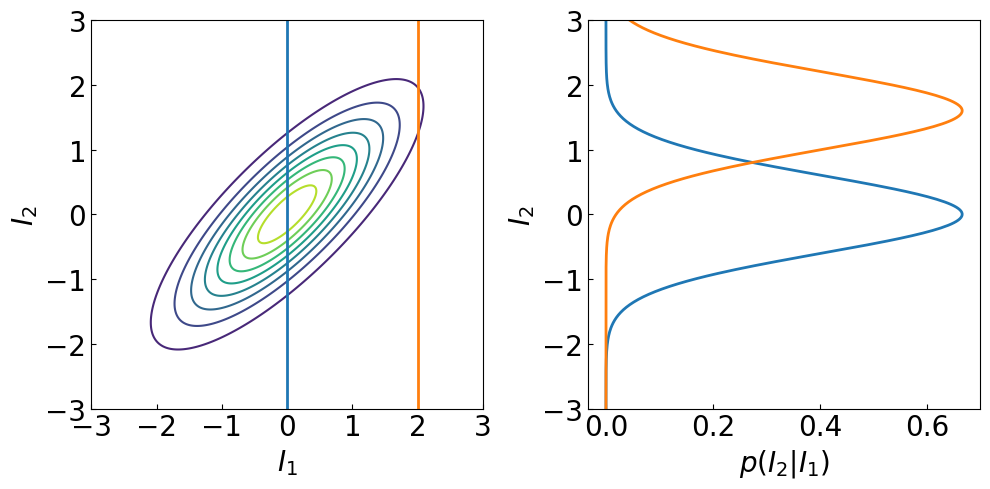

In [22]:
from scipy.stats import multivariate_normal
from scipy.stats import norm

# Define mean and covariance
mu = np.array([0.0, 0.0])
Sigma = np.array([[1.0, 0.8],
                  [0.8, 1.0]])

# Create a grid of (x, y) points
x = np.linspace(-3.0, 3.0, 300)
y = np.linspace(-3.0, 3.0, 300)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))  # Shape: (n, n, 2)

# Evaluate the 2D Gaussian PDF over the grid
rv = multivariate_normal(mean=mu, cov=Sigma)
Z = rv.pdf(pos)

# Plot the contour
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(1,2, 1)
# You can tweak the number of contour levels or use plt.contourf for filled contours
CS = ax.contour(X, Y, Z, levels=8, cmap='viridis')
ax.plot([0,0],[-3,3],'-',color='C0', lw=2)
ax.plot([2,2],[-3,3],'-',color='C1', lw=2)
ax.set_xlabel(r"$I_1$", fontsize=20)
ax.set_ylabel(r"$I_2$", fontsize=20)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
ax.set_xticks([-3,-2,-1,0,1,2,3])
ax.set_yticks([-3,-2,-1,0,1,2,3])

ax.tick_params(direction='in', labelsize=20)

# Plot the 1D conditional probability of I2 given I1=0 and I1=2
# For a bivariate normal with mean=[mu1, mu2] and covariance=[[σ1², ρσ1σ2],
#                                                             [ρσ1σ2, σ2²]],
# the conditional distribution I2|I1=x is normal with:
#   mean = mu2 + ρ*(σ2/σ1)*(x - mu1)
#   var  = σ2² * (1 - ρ²).


# Extract parameters from mu and Sigma
mu1, mu2 = mu
sigma1 = np.sqrt(Sigma[0, 0])
sigma2 = np.sqrt(Sigma[1, 1])
rho = Sigma[0, 1] / (sigma1 * sigma2)

def conditional_mean(x, mu1, mu2, sigma1, sigma2, rho):
    return mu2 + rho*(sigma2/sigma1)*(x - mu1)

def conditional_std(sigma2, rho):
    return sigma2 * np.sqrt(1 - rho**2)

cond_std = conditional_std(sigma2, rho)

# Define grid for plotting the conditional pdf
I2_vals = np.linspace(-3, 3, 300)

# Conditional distributions for I1=0 and I1=2
mean_I1_0 = conditional_mean(0, mu1, mu2, sigma1, sigma2, rho)
pdf_I1_0 = norm.pdf(I2_vals, loc=mean_I1_0, scale=cond_std)

mean_I1_2 = conditional_mean(2, mu1, mu2, sigma1, sigma2, rho)
pdf_I1_2 = norm.pdf(I2_vals, loc=mean_I1_2, scale=cond_std)

# Plot
ax2 = plt.subplot(1,2, 2)
ax2.plot(pdf_I1_0, I2_vals, label="I2 | I1=0", lw=2)
ax2.plot(pdf_I1_2, I2_vals, label="I2 | I1=2", lw=2)
ax2.set_xlabel("$p(I_2|I_1)$", fontsize=20)
ax2.set_ylabel(r"$I_2$", fontsize=20)
ax2.tick_params(direction='in', labelsize=20)
ax2.set_ylim([-3,3])
# ax2.legend(fontsize=16, frameon=False)

plt.tight_layout()